# SVM with Docking Scores

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append('..')

In [2]:
from modules.plotting_metrics import PlotMetric

## Ensemble Docking con ligandos CSAR
- #### 111 ligandos
    - 27 Activos
- #### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [3]:
def open_results(path, column_to_drop, active_label='Active'):
    '''Function to load VS results from path file. It returns X and y ndarrays.'''
    path_file = os.path.join(*path.split('/'))
    df_results = pd.read_csv(path_file, index_col=0)
    y_ = pd.Series(df_results[column_to_drop] == active_label, dtype = int) # Setting y_true
    X_ = df_results.drop([column_to_drop], axis = 1) # Setting X
    return X_, y_

In [4]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_CSAR, y_dksc_CSAR = open_results(path = '../data/vs_docking_crys_ensemble_VINARDO.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dksc_CSAR", X_dksc_CSAR.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_CSAR, y_dkef_CSAR = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_CSAR_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dkef_CSAR", X_dkef_CSAR.shape)

Dims X_dksc_CSAR (111, 402)
Dims X_dkef_CSAR (111, 402)


## Ensemble Docking con ligandos DUD (2006)
- ### 2146 ligandos
    - 72 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [5]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DUD, y_dksc_DUD = open_results(path = '../data/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dksc_DUD", X_dksc_DUD.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_DUD, y_dkef_DUD = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_DUD2006_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dkef_DUD", X_dkef_DUD.shape)

Dims X_dksc_DUD (2146, 402)
Dims X_dkef_DUD (2146, 402)


In [130]:
# Finally we create adictionary that we will use to combine different approaches
scores_dic = {'CSAR': {'DkSc':  {'X': X_dksc_CSAR, 'y': y_dksc_CSAR}, 
                       'DkLEff': {'X': X_dkef_CSAR, 'y': y_dkef_CSAR} },
              'DUD':  {'DkSc':  {'X': X_dksc_DUD,  'y': y_dksc_DUD}, 
                       'DkLEff': {'X': X_dkef_DUD,  'y': y_dkef_DUD} }
             }

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer, f1_score

In [123]:
'''Default scorer used by GridSearch in SVM'''
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True, needs_proba=False)

def run_SVM(X_train, X_test, y_train, y_test, 
            C = np.geomspace(0.01, 100, 5), kernel='linear', 
            scoring = roc_auc_scorer, extra_params_dict = None,
            k_folds = 5, **kwargs):
    '''
     1) Pipeline is created, and will perform StandarScaler
    '''
    SVCpipe = Pipeline([
            ("scaler", StandardScaler()),
            ("SVC", SVC(probability=True, **kwargs))])
    '''
    2) If specific hyperparameters are given, we will parse them to the
    gridSearch instance.
    '''
    params = {'SVC__C': C, 'SVC__kernel': [kernel]}
    if extra_params_dict != None:
        for key, value in extra_params_dict.items():
            params[key] = value
    '''
    3) Grid search cross validation for turning the optimal parameters, 
    it takes the pipeline object. GridSearch performs k-fold cross validation, 
    and uses the given scoring method to validate each set.
    '''
    linear_SVC = GridSearchCV(estimator = SVCpipe, param_grid = params, cv = k_folds, 
                              scoring = scoring, n_jobs = 6, refit=True)
    '''SVC training through GridSearch object'''
    linear_SVC.fit(X_train, y_train)
    '''
    4) Predictions and evaluation on the Test set
    - Scaling and prediction of X_train using the best model found by grid
    '''
    y_prob  = linear_SVC.predict_proba(X_test)[:,1] # Predicted prob values for X_test
    y_score = linear_SVC.decision_function(X_test) # Hyperplane distances
    y_pred  = linear_SVC.predict(X_test) # predicted values
    '''Returns the y_score values and the lnear_SVC object'''
    return(y_score, linear_SVC)

In [145]:
def model_wrapper(train_key, test_key, list_of_scores, model, 
                  scores_dic = scores_dic, decreasing = False, **kwargs):
    y_preds = {}; trained_models = {}
    for score in list_of_scores:
        X_train = scores_dic[train_key][score]['X']
        y_train = scores_dic[train_key][score]['y']
        X_test  = scores_dic[test_key][score]['X']
        y_test  = scores_dic[test_key][score]['y']
        # Runs the model
        y_preds[score], trained_models[score] = model(X_train, X_test, 
                                                      y_train, y_test, **kwargs)
    # Invoke PlotMetric Class
    model_results = PlotMetric(y_true = y_test, y_pred_dict = y_preds, decreasing=decreasing)
    return(model_results, trained_models)

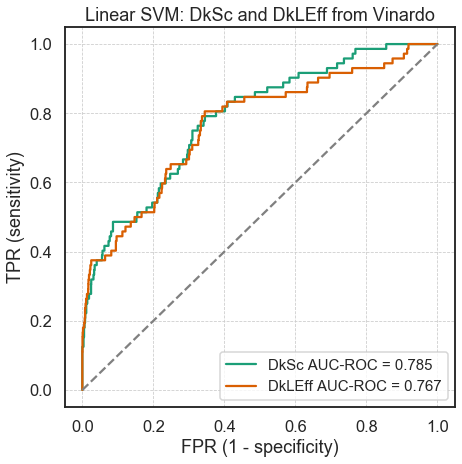

In [148]:
linear_svm, _ = model_wrapper(train_key = 'CSAR', test_key = 'DUD', 
                           list_of_scores = ['DkSc', 'DkLEff'], model = run_SVM, 
                           scores_dic = scores_dic, decreasing = False)
linear_svm.plot_roc_auc('Linear SVM: DkSc and DkLEff from Vinardo')

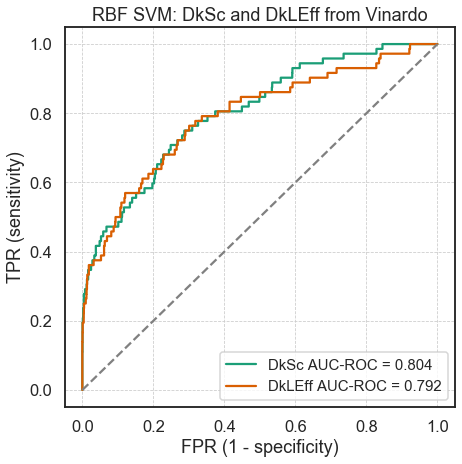

In [150]:
svc_params = {'SVC__gamma': [0.001, 0.01, 1, 10],
             'SVC__C': np.geomspace(0.01, 100, 5),
             'SVC__kernel': ['rbf']}

rbf_svm, _ = model_wrapper(train_key = 'CSAR', test_key = 'DUD', 
                           list_of_scores = ['DkSc', 'DkLEff'], model = run_SVM, 
                           scores_dic = scores_dic, decreasing = False,
                          extra_params_dict = svc_params)
rbf_svm.plot_roc_auc('RBF SVM: DkSc and DkLEff from Vinardo')

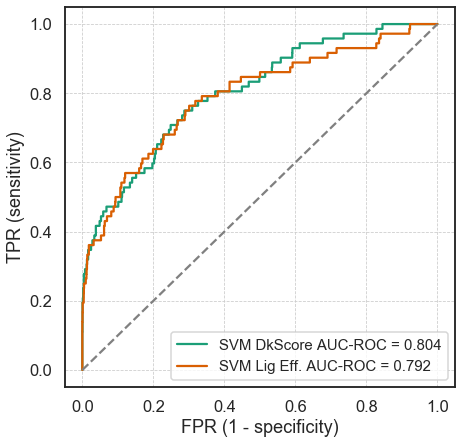

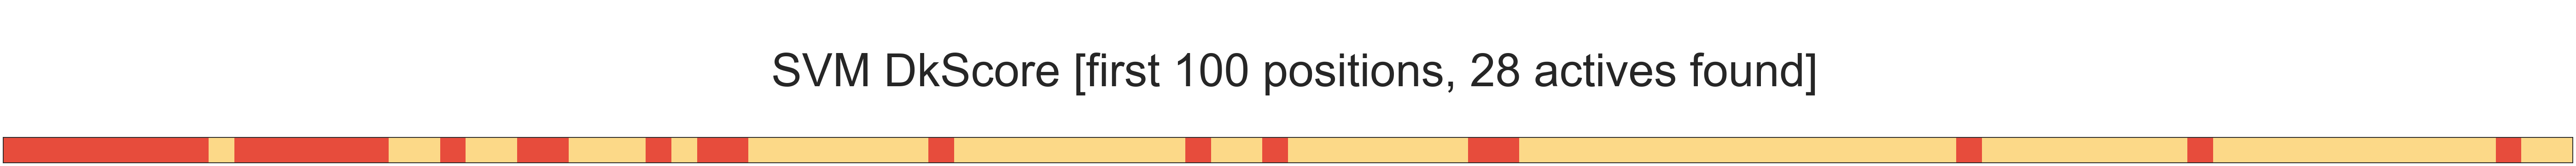

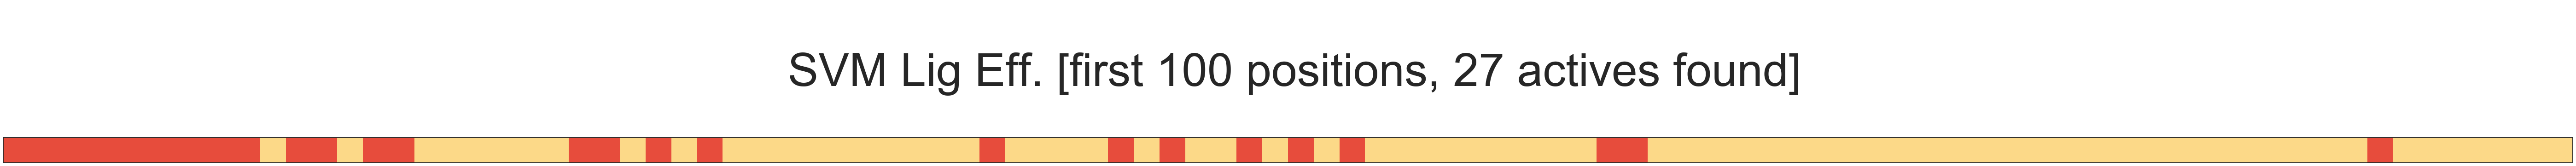

In [122]:
svc_params = {'SVC__gamma': [0.001, 0.01, 1, 10],
             'SVC__C': np.geomspace(0.01, 100, 5),
             'SVC__kernel': ['rbf']}

X_train = X_dksc_CSAR; y_train = y_dksc_CSAR
X_test = X_dksc_DUD; y_test = y_dksc_DUD
y_score_dksc, svc_dksc = run_SVM(X_train, X_test, y_train, y_test, 
                                 extra_params_dict = svc_params)

X_train = X_dkef_CSAR; y_train = y_dkef_CSAR
X_test = X_dkef_DUD; y_test = y_dkef_DUD
y_score_dkef, svc_dkef = run_SVM(X_train, X_test, y_train, y_test, 
                                 extra_params_dict = svc_params)

svm_preds = {'SVM DkScore': y_score_dksc, 'SVM Lig Eff.': y_score_dkef}
svm_rocs = PlotMetric(y_true = y_test, y_pred_dict = svm_preds,
                     decreasing = False)
svm_rocs.plot_roc_auc('')
svm_rocs.plot_actives_distribution(max_position_to_plot=100)

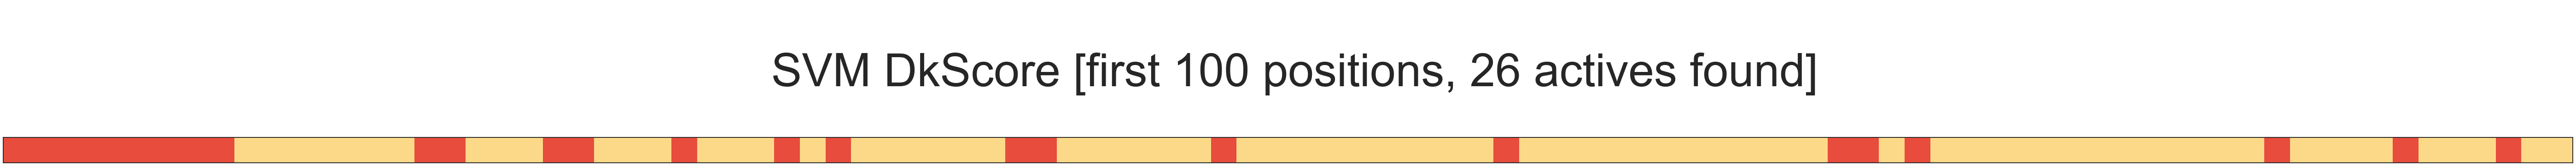

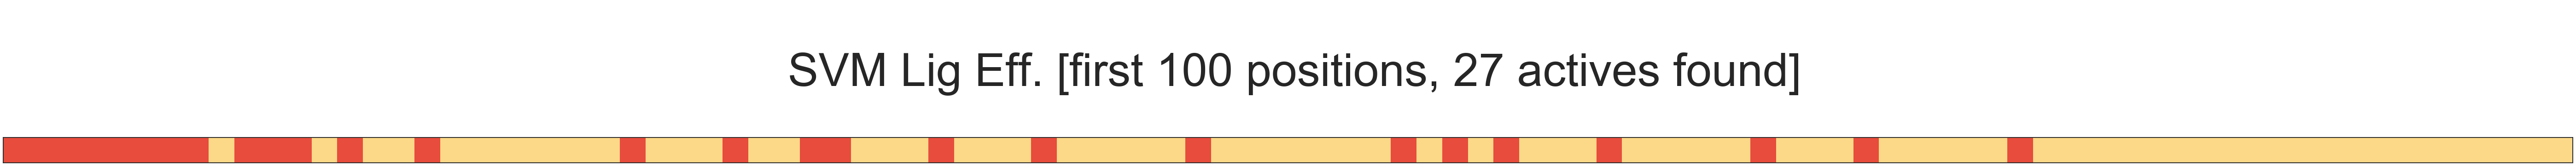

In [33]:
svm_rocs.plot_actives_distribution(max_position_to_plot=100)

Matriz de confusión:
 [[1957  117]
 [  41   31]]
Matriz de confusión:
 [[1904  170]
 [  43   29]]


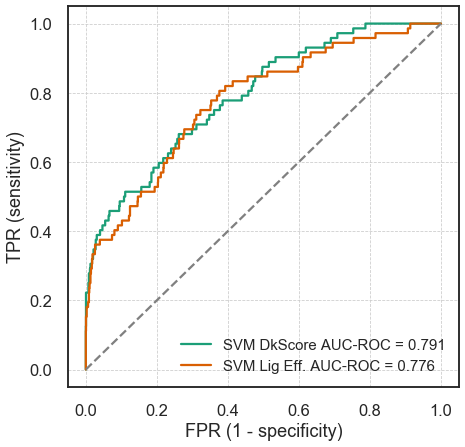

In [48]:
svc_params = {'SVC__degree': [2, 3, 4], 'SVC__coef0':[0, 1, 2]}

X_train = X_dksc_CSAR; y_train = y_dksc_CSAR
X_test = X_dksc_DUD; y_test = y_dksc_DUD
y_score_dksc, y_pred_dksc, svc_dksc = run_SVM(X_train, X_test, y_train, y_test, kernel='poly',
                                 extra_params_dict = svc_params)

X_train = X_dkef_CSAR; y_train = y_dkef_CSAR
X_test = X_dkef_DUD; y_test = y_dkef_DUD
y_score_dkef, y_pred_dkef, svc_dkef = run_SVM(X_train, X_test, y_train, y_test, kernel='poly', 
                                 extra_params_dict = svc_params)

svm_preds = {'SVM DkScore': y_score_dksc, 'SVM Lig Eff.': y_score_dkef}
svm_rocs = PlotMetric(y_true = y_test, y_pred_dict = svm_preds,
                     decreasing = False)
svm_rocs.plot_roc_auc('')

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

/home/linuxlite/anaconda3/envs/mds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[1971  103]
 [  43   29]]


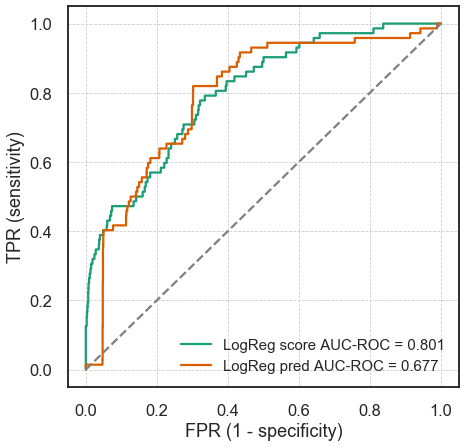

In [61]:
X_train = X_dksc_CSAR; y_train = y_dksc_CSAR
X_test = X_dksc_DUD; y_test = y_dksc_DUD

logReg = LogisticRegression().fit(X_train, y_train)

y_pred = logReg.predict(X_test)
y_score = logReg.decision_function(X_test)

print(confusion_matrix(y_true= y_test, y_pred = y_pred))

lrg_preds = {'LogReg score': y_score, 'LogReg pred': y_pred}
lrg_rocs = PlotMetric(y_true = y_test, y_pred_dict = lrg_preds,
                     decreasing = False)
lrg_rocs.plot_roc_auc('')

In [62]:
len(y_score[y_score >= 0])

132

In [68]:
y_score.sort()
y_score[::-1]

array([ 11.12650635,  10.78671352,   9.74786275, ..., -10.96826667,
       -12.14252613, -13.90909074])

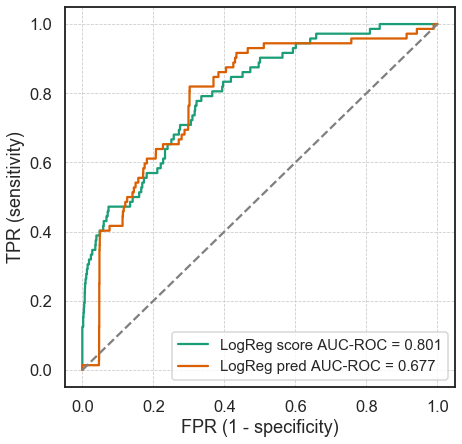

In [25]:
y_pred.sum()

132